# SCRIPT FUNCTION

- requires pre-epoched data  
- combines separate epoch files from each session into a single dataset
- power spectra 
- time frequency analysis of epoch segments
- comaprison of high vs low brain states

In [1]:
#LOAD MODULES
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import signal
from random import randrange
from numpy import shape as s
import mne
import os
import sys


In [2]:
# LOAD AND CONCATENATE EPOCH FILES FOR DIFFERENT SESSIONS 

os.chdir(r'C:\Users\rhyso\eegdata')
import mbp

epochs1 = mne.read_epochs('epochs_GW_12_12_19-epo.fif', preload= False)
epochs2 = mne.read_epochs('epochs_GW_13_12_19-epo.fif', preload= False)
epochs3 = mne.read_epochs('epochs_GW_17_12_19-epo.fif', preload= False)
epochs4 = mne.read_epochs('epochs_GW_18_12_19-epo.fif', preload= False)
epochs5 = mne.read_epochs('epochs_GW_21_01_20-epo.fif', preload= False)
epochs6 = mne.read_epochs('epochs_GW_22_01_20-epo.fif', preload= False)
epochs7 = mne.read_epochs('epochs_GW_29_01_20-epo.fif', preload= False)
epochs8 = mne.read_epochs('epochs_GW_29_11_19-epo.fif', preload= False)
epochs9 = mne.read_epochs('epochs_GW_30_01_20-epo.fif', preload= False)
epochs10 = mne.read_epochs('epochs_GW_30_11_19-epo.fif', preload= False)
epochs_list = [epochs1,epochs2,epochs3,epochs4,epochs5,epochs6,epochs7,epochs8,epochs9,epochs10]

all_epochs = mne.concatenate_epochs(epochs_list)
good_chans = ['CH1 F7-O1', 'CH3 Fp1-F8', 'CH4 F8-F7', 'CH5 Fp1-O1', 'CH7 FP1-F7']
mne.Epochs.pick_channels(all_epochs, ch_names = good_chans)

Reading epochs_GW_12_12_19-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =  -20000.00 ...   30000.00 ms
        0 CTF compensation matrices available
11 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading epochs_GW_13_12_19-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =  -20000.00 ...   30000.00 ms
        0 CTF compensation matrices available
9 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading epochs_GW_17_12_19-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =  -20000.00 ...   30000.00 ms
        0 CTF compensation matrices available
13 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading epochs_GW_18_12_19-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =  -20000.00 ...   3000

<Epochs  |   119 events (all good), -20 - 30 sec, baseline [-20, 0], ~56.8 MB, data loaded,
 '1': 119>

119 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


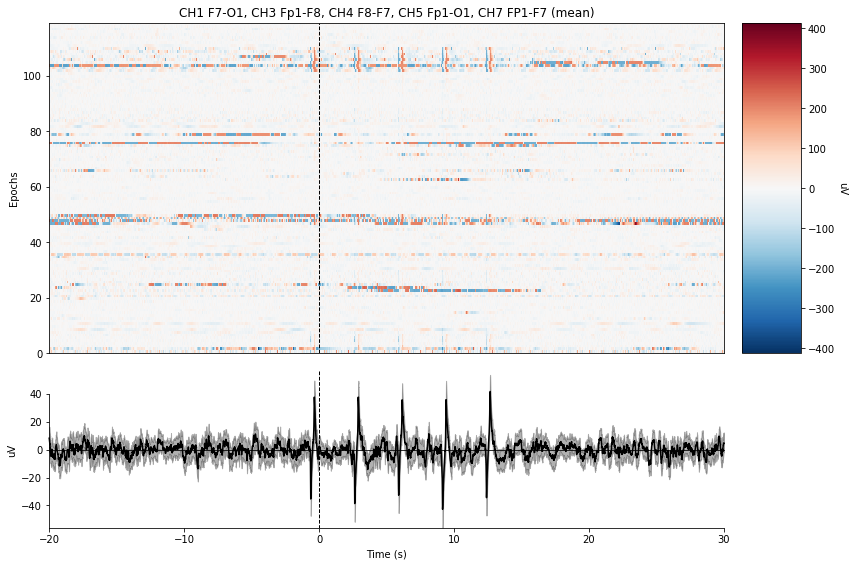

In [6]:
#Plot a graph of EEG signal over time. Each epoch visualised individually on y axis and average displayed separately. 
fig = plt.rcParams["figure.figsize"]= [12, 8]
fig = mne.Epochs.plot_image(all_epochs, picks = good_chans, combine='mean')

<IPython.core.display.Javascript object>


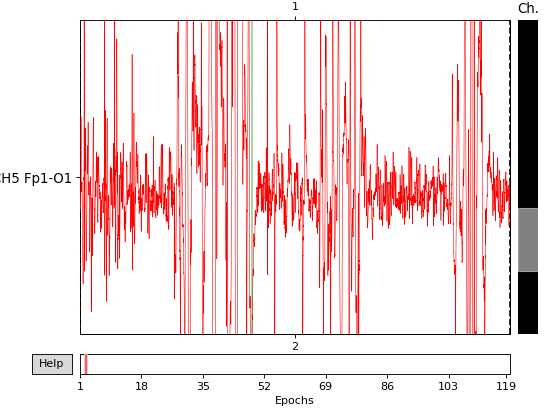

<IPython.core.display.Javascript object>


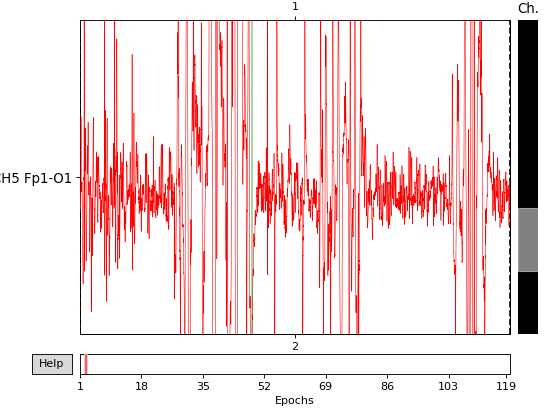

In [3]:
import matplotlib
%matplotlib notebook
mne.Epochs.plot(all_epochs, picks = good_chans, n_epochs = 1, n_channels = 1, block = True)


In [3]:
# GENERATE POWER SPECTRA 

import mne.time_frequency as tf 

# Use Welch's/Hanning window
psds_welch_mean, freqs_mean = tf.psd_welch(all_epochs, average='mean', picks = good_chans, fmin = 1, fmax = 15, n_jobs = 1)
psds_epoch_avg = np.mean(psds_welch_mean, axis = 0) # take mean across epoch dimension
psds_epoch_avg = 10 * np.log10(psds_epoch_avg) #convert to dB scale


Effective window size : 1.024 (s)


<IPython.core.display.Javascript object>


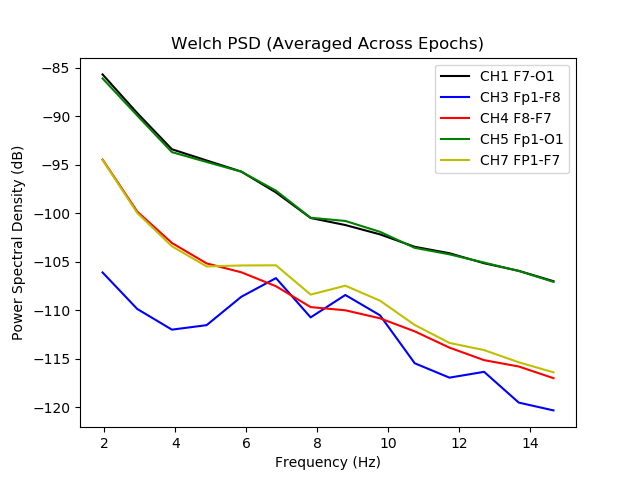

In [32]:
#PLOT POWER SPECTRA FOR EACH CHANNEL

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_epoch_avg[0,:], color = 'k', label = good_chans[0])
ax.plot(freqs_mean, psds_epoch_avg[1,:], color = 'b', label = good_chans[1])
ax.plot(freqs_mean, psds_epoch_avg[2,:], color = 'r', label = good_chans[2])
ax.plot(freqs_mean, psds_epoch_avg[3,:], color = 'g', label = good_chans[3])
ax.plot(freqs_mean, psds_epoch_avg[4,:], color = 'y', label = good_chans[4])
ax.set(title='Welch PSD (Averaged Across Epochs)',
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc = 'upper right')
plt.show()

In [66]:
#TIME FREQUENCY ANALYSIS

# Extraction of numpy array from epoch data is required. This is because the mne.STFT function requires an input with the 
# shape: (n_signals, n_timepoints) and therefore requires each epoch to analysed separately.
np_epochs = mne.Epochs.get_data(all_epochs, picks = good_chans)
dim_check = np_epochs.shape
print('Epoch time series: The number of epochs is:', dim_check[0])
print('Epoch time series: The number of eeg channels is:', dim_check[1])
print('Epoch time series: The number of timepoints per epoch is:', dim_check[2])

# CALCULATE STFT DIMENSIONS
window_width = 200 # trade off between time and freq resolution. Increase value to increase frequency resolution
test_stft = tf.stft(np_epochs[0,:,:], wsize = window_width, tstep = None, verbose = None)
stft_dim = [test_stft.shape[0], test_stft.shape[1], test_stft.shape[2]] 
stft_freqs = tf.stftfreq(window_width, sfreq = 250) # list of frequencies in Hz
stft_times = np.linspace(start = -20, stop = 30, num = stft_dim[2]) # list of timepoints in seconds 
print('STFT: the number of channels is', stft_dim[0])
print('STFT: the number of frequencies is', stft_dim[1])
print('STFT: the number of timepoints is', stft_dim[2])

#CALCULATE STFT FOR ALL EPOCHS THEN AVERAGE

cmb_stft = np.zeros((dim_check[0], stft_dim[0], stft_dim[1], stft_dim[2])) #Generate empty 4D array with appropriate shape

#iterate through epochs and calculate stft
for i in range(dim_check[0]):
    ind_epoch = np_epochs[i,:,:]
    cmb_stft[i,:,:,:] = tf.stft(ind_epoch, wsize = window_width, tstep = None, verbose = None)
    
cmb_stft = np.abs(cmb_stft) # take absolute values, only phase info lost
cmb_stft = np.mean(cmb_stft, axis = 0) # average across epoch dimension

# STORE DATA IN AN MNE FORMAT 
tfr = tf.AverageTFR(info = all_epochs.info, data = cmb_stft, nave = dim_check[0], freqs = stft_freqs, times = stft_times,
                    verbose = None) 

Epoch time series: The number of epochs is: 119
Epoch time series: The number of eeg channels is: 5
Epoch time series: The number of timepoints per epoch is: 12501
Number of frequencies: 101
Number of time steps: 126
STFT: the number of channels is 5
STFT: the number of frequencies is 101
STFT: the number of timepoints is 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of

C:\Users\rhyso\anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencies: 101
Number of time steps: 126
Number of frequencie

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>


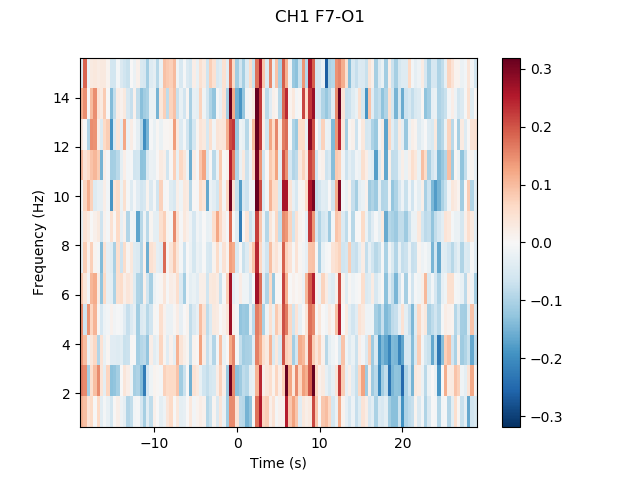

<IPython.core.display.Javascript object>


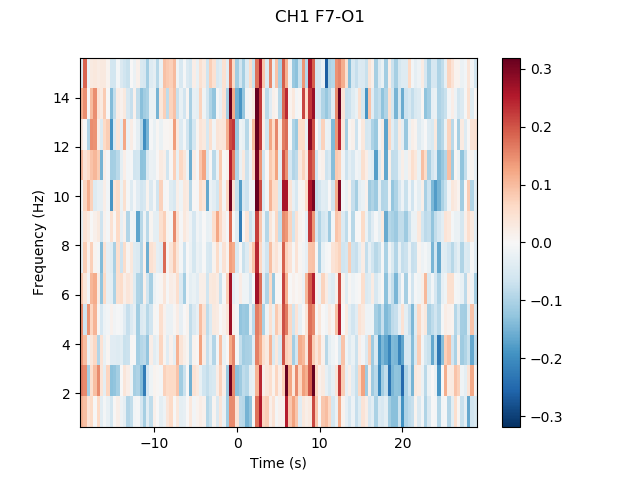

In [81]:
#PLOT TIME FREQUENCY REPRESENTATIONS

tf.AverageTFR.plot(tfr, baseline = [-19, -4], mode = 'logratio', fmin = 1, fmax = 15, tmin = -19, 
                   tmax = 29, picks = tfr.ch_names[0])

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>


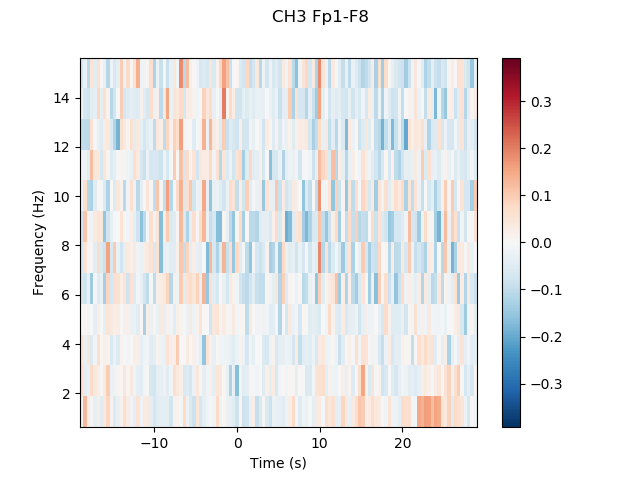

<IPython.core.display.Javascript object>


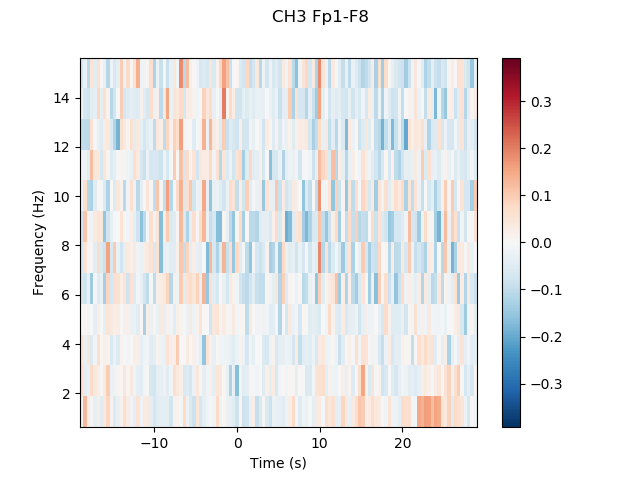

In [82]:
tf.AverageTFR.plot(tfr, baseline = [-19, -4], mode = 'logratio', fmin = 1, fmax = 15, tmin = -19, 
                   tmax = 29, picks = tfr.ch_names[1])

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>


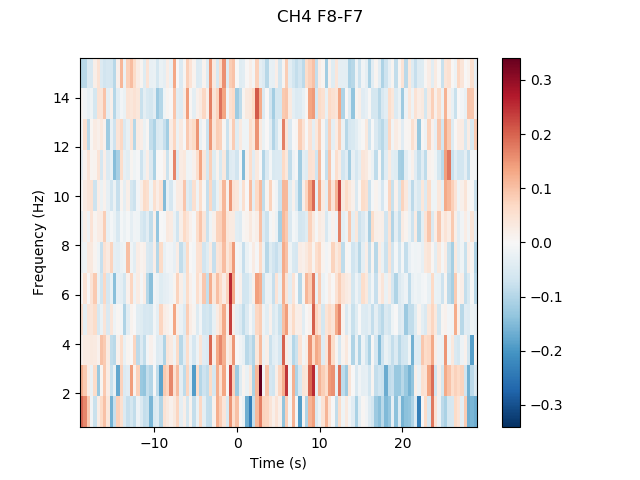

<IPython.core.display.Javascript object>


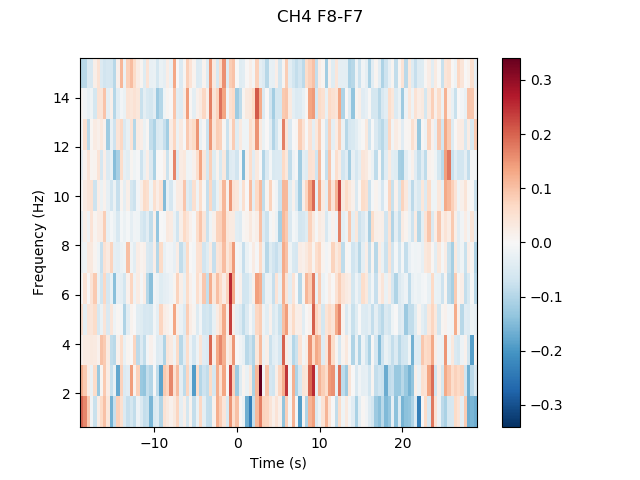

In [83]:
tf.AverageTFR.plot(tfr, baseline = [-19, -4], mode = 'logratio', fmin = 1, fmax = 15, tmin = -19, 
                   tmax = 29, picks = tfr.ch_names[2])

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>


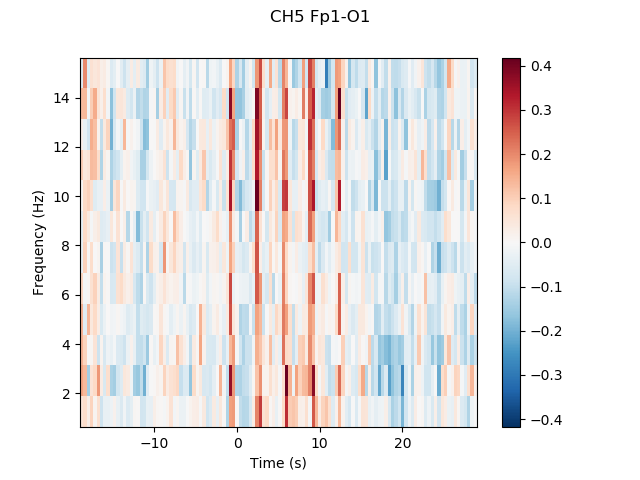

<IPython.core.display.Javascript object>


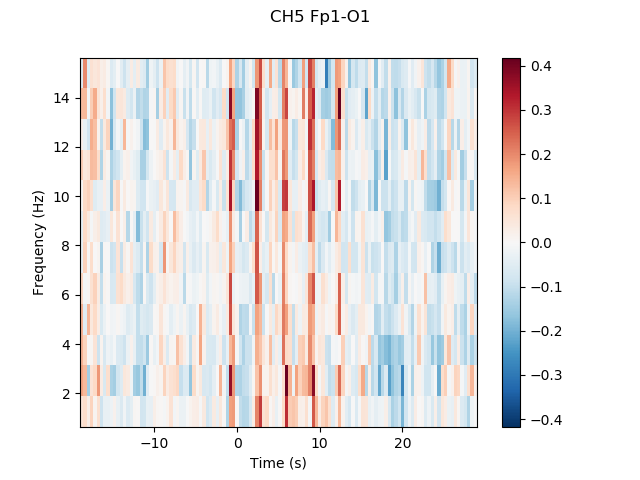

In [84]:
tf.AverageTFR.plot(tfr, baseline = [-19, -4], mode = 'logratio', fmin = 1, fmax = 15, tmin = -19, 
                   tmax = 29, picks = tfr.ch_names[3])

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>


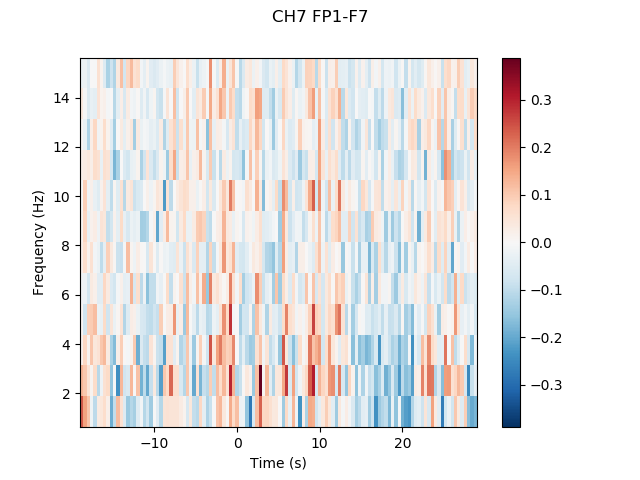

<IPython.core.display.Javascript object>


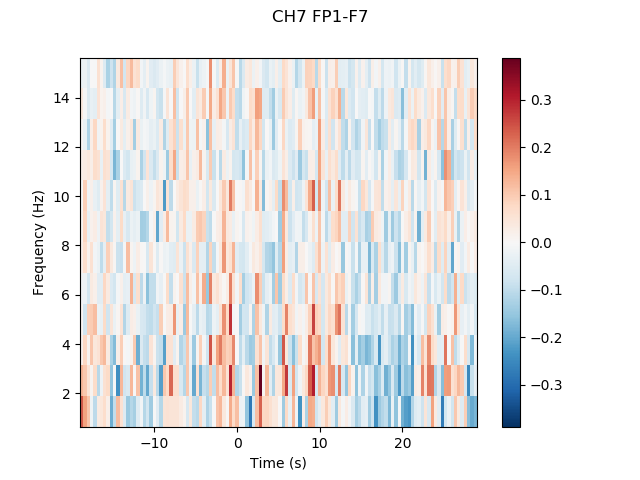

In [85]:
tf.AverageTFR.plot(tfr, baseline = [-19, -4], mode = 'logratio', fmin = 1, fmax = 15, tmin = -19, 
                   tmax = 29, picks = tfr.ch_names[4])

In [7]:
# POWER SPECTRA BEFORE AND AFTER STIMULI

# Extract baseline and response segments 
base_epochs = mne.Epochs.copy(all_epochs)
mne.Epochs.crop(base_epochs, tmin = -19, tmax = -4) #baseline period -19s to -4s 
resp_epochs = mne.Epochs.copy(all_epochs)
mne.Epochs.crop(resp_epochs, tmin = 14, tmax = 29) # response period 14s to 29s after stimulus train

# Use Welch's/Hanning window to generate power spectra

# baseline period
base_welch, freqs_mean = tf.psd_welch(base_epochs, average='mean', picks = good_chans, fmin = 1, fmax = 15, n_jobs = 1)
print('The number of negative values is:', np.sum(base_welch<0)) # confirm absence of negative psds values before taking mean
base_welch = np.mean(base_welch, axis = 0) # take mean across epoch dimension
base_welch = 10 * np.log10(base_welch) #convert to dB scale

# response period
resp_welch, freqs_mean = tf.psd_welch(resp_epochs, average='mean', picks = good_chans, fmin = 1, fmax = 15, n_jobs = 1)
print('The number of negative values is:', np.sum(resp_welch<0)) # confirm absence of negative psds values before taking mean
resp_welch = np.mean(resp_welch, axis = 0) # take mean across epoch dimension
resp_welch = 10 * np.log10(resp_welch) #convert to dB scale


Effective window size : 1.024 (s)
The number of negative values is: 0
Effective window size : 1.024 (s)
The number of negative values is: 0


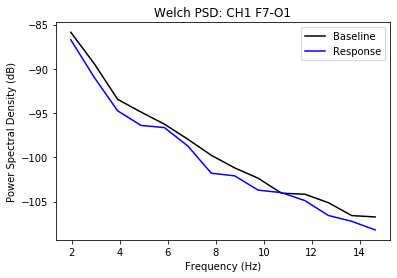

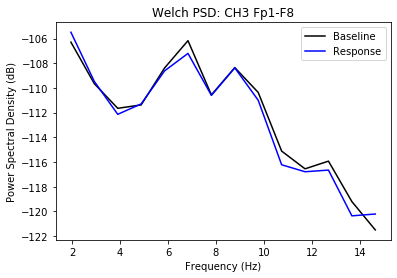

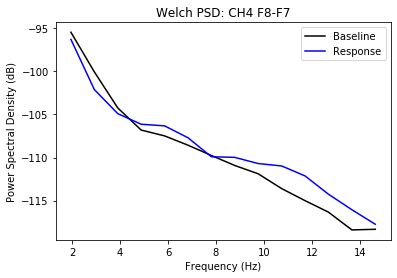

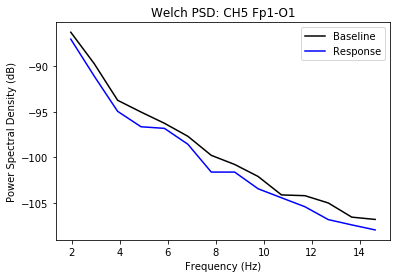

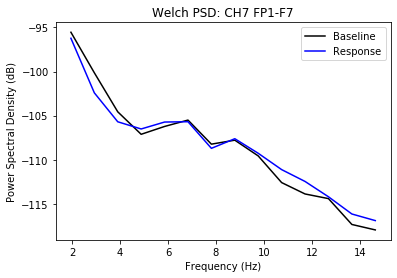

In [13]:
# PLOT POWER SPECTRA

ps_labels = ['Baseline', 'Response']

for i in range(len(good_chans)):
    _, ax = plt.subplots()
    ax.plot(freqs_mean, base_welch[i,:], color = 'k', label = labels[0])
    ax.plot(freqs_mean, resp_welch[i,:], color = 'b', label = labels[1])
    ps_title = 'Welch PSD: ' + good_chans[i]
    ax.set(title= ps_title, xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
    ax.legend(loc = 'upper right')
    plt.show()

N.o. chans 5
N.o. epochs 119
N.o. freqs 139
N.o freqs within band of interest 15


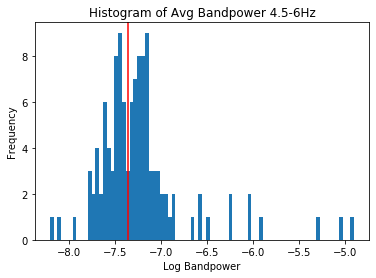

The number of high brain state epochs 67
The number of low brain state epochs 52


In [71]:
# SUBDIVIDE EPOCHS INTO HIGH AND LOW BRAIN STATES 

#create numpy array from baseline period of epoch data
np_epochs = mne.Epochs.copy(all_epochs)
np_epochs = mne.Epochs.crop(np_epochs, tmin = -19, tmax = -4)
np_epochs = mne.Epochs.get_data(np_epochs)
np_epochs.shape

# initialise 
dft_freqs = np.arange(1, 15, 0.1) # select frequencies of interest
base_dft = np.zeros((len(good_chans), np_epochs.shape[0], len(dft_freqs)-1)) # create empty dft array

#iterate through channels and calculate dft
for i in range(len(good_chans)):
    base_dft[i,:,:] = np.squeeze(mbp.mbp(np_epochs[:,i,:], freqs = dft_freqs, fs = 250)) 

# check expected dimensions
print('N.o. chans', base_dft.shape[0])
print('N.o. epochs', base_dft.shape[1])
print('N.o. freqs', base_dft.shape[2])

#identify indices of dft_freqs between 4.5 and 6Hz 
freq_lim = [4.5, 6]
freq_index = np.where((dft_freqs >= freq_lim[0]) & (dft_freqs <= freq_lim[1]))[0] 
print('N.o freqs within band of interest', len(freq_index))

#Generate mean power values for frequency of interest
avg_bandpower = np.zeros(base_dft.shape[1]) # create empty array with length = number of epochs

#iterate through epochs
for i in range(base_dft.shape[1]):
    avg_bandpower[i] = np.mean(base_dft[2,i,freq_index], axis = 0)
avg_bandpower

# PLOT histograms of avg 4.5-6Hz power across individual epochs 
plt.hist(avg_bandpower, bins = 80)
plt.title('Histogram of Avg Bandpower 4.5-6Hz')
plt.xlabel('Log Bandpower')
plt.ylabel('Frequency')
plt.axvline(x=-7.35, color = 'r')
plt.show()

#identify epoch indices corresponding to high and low brain states
high_index = np.where(avg_bandpower > -7.35)[0]
print('The number of high brain state epochs', len(high_index))
low_index = np.where(avg_bandpower <= -7.35)[0]
print('The number of low brain state epochs', len(low_index))

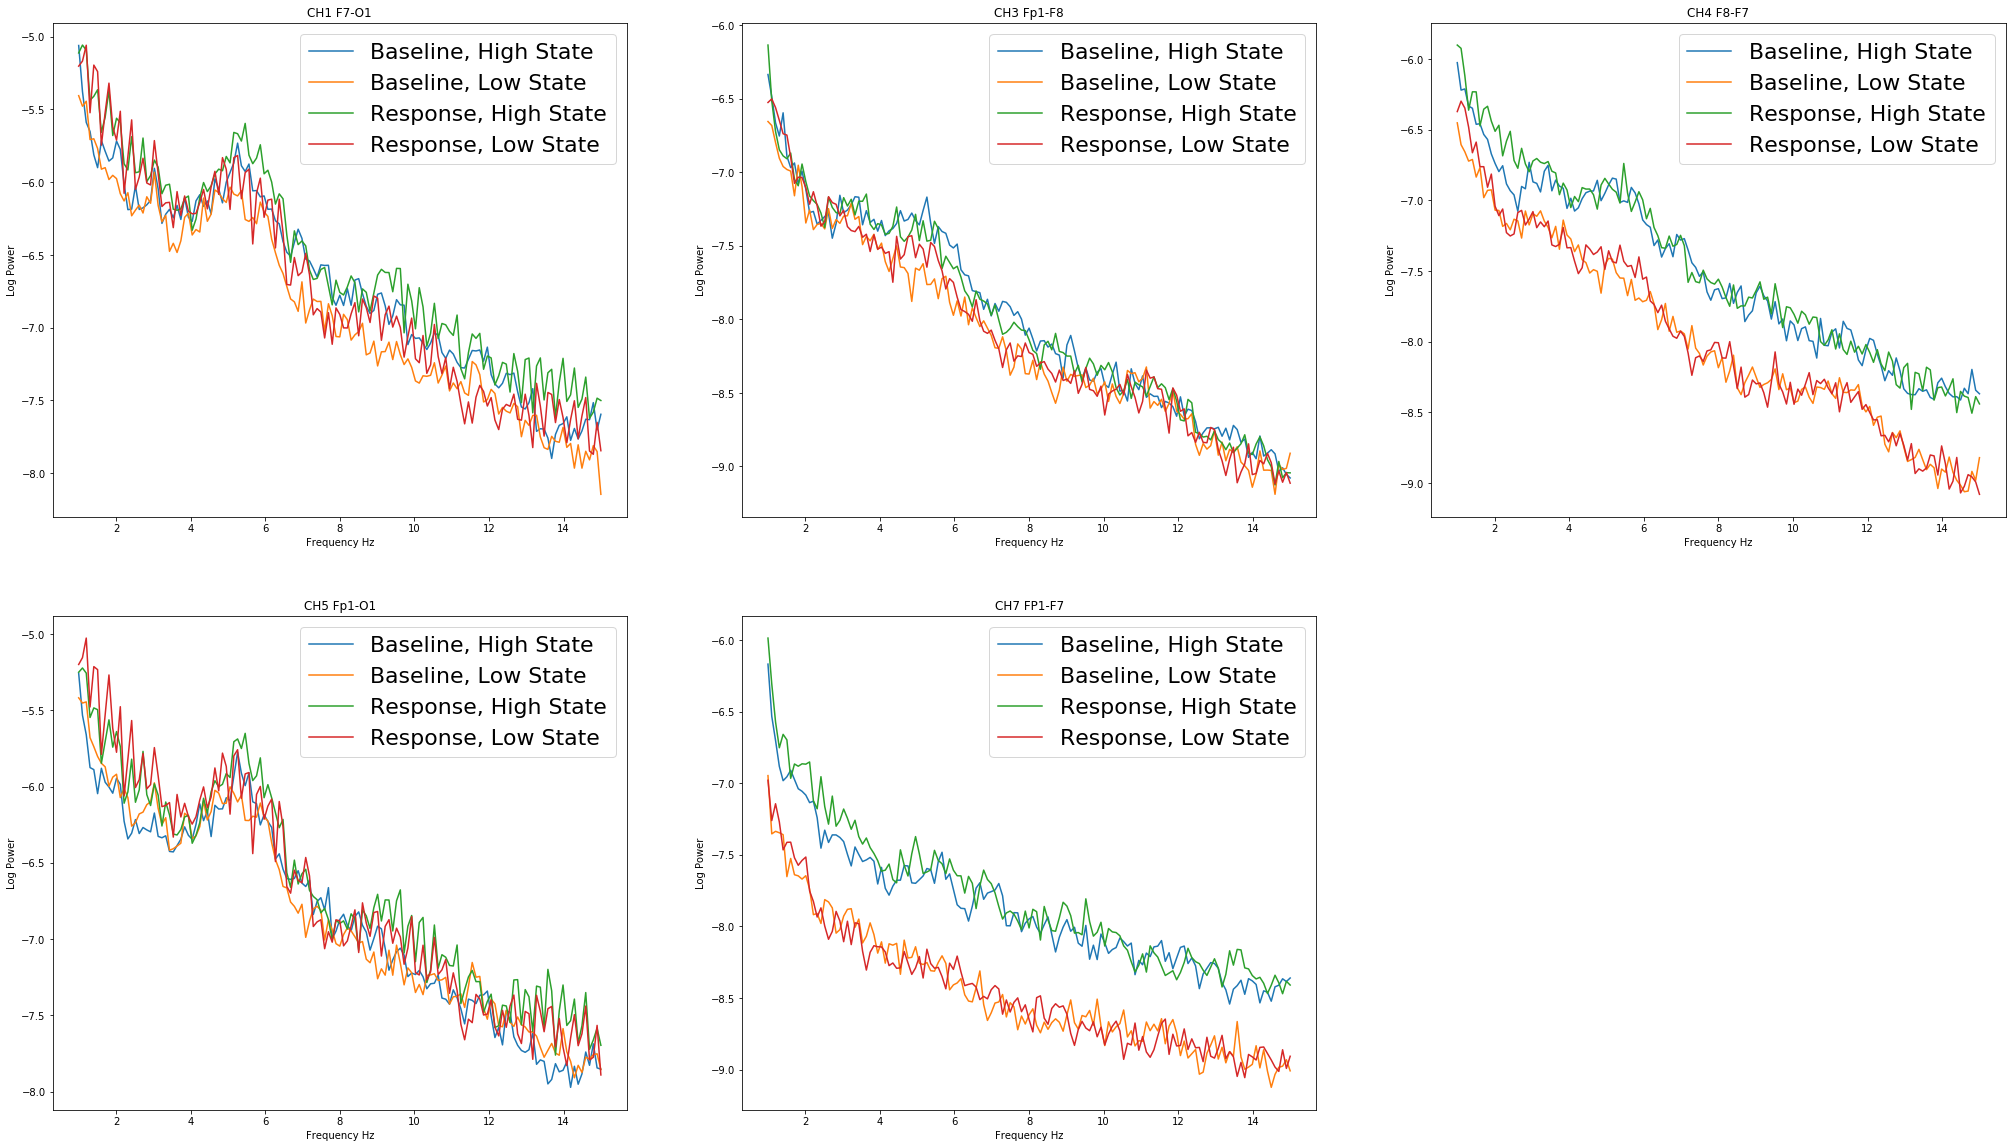

In [89]:
# PLOT POWER SPECTRA: HIGH VS LOW BRAIN STATE & BASELINE VS RESPONSE

# generate dft for response period
np_epochs = mne.Epochs.copy(all_epochs)
np_epochs = mne.Epochs.crop(np_epochs, tmin = 4, tmax = 19)
np_epochs = mne.Epochs.get_data(np_epochs)

# initialise 
resp_dft = np.zeros((len(good_chans), np_epochs.shape[0], len(dft_freqs)-1)) # create empty dft array

#iterate through channels and calculate dft
for i in range(len(good_chans)):
    resp_dft[i,:,:] = np.squeeze(mbp.mbp(np_epochs[:,i,:], freqs = dft_freqs, fs = 250)) 


#for each channel, plot power spectra for the 4 conditions
adj_freqs = np.linspace(1, 15, num = 139) # true length of dft frequencies  = dft_freqs - 1
plt.figure( figsize = (35,20))
for i in range(len(good_chans)):
    plt.subplot(2,3,i+1)
    plt.plot(adj_freqs, np.mean(base_dft[i, high_index, :], axis = 0), label = 'Baseline, High State')
    plt.plot(adj_freqs, np.mean(base_dft[i, low_index, :], axis = 0), label = 'Baseline, Low State')
    plt.plot(adj_freqs, np.mean(resp_dft[i, high_index, :], axis = 0),label = 'Response, High State')
    plt.plot(adj_freqs, np.mean(resp_dft[i, low_index, :], axis = 0), label = 'Response, Low State')
    plt.title(good_chans[i])
    plt.xlabel('Frequency Hz')
    plt.ylabel('Log Power')
    plt.legend(loc = 'upper right', prop={'size': 22})
plt.show()
